# For UAV sites, get ICESat-2/ATLAS vegetation height data  
### label ATL03 photons with ATL08 classification

| Author | Affiliation | Date 
| ---------------- | ---------------- | ---------------- 
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Aug. 2024 

### Summary:

- Choose an expedition and a site with UAV data
- Footprint the UAV COGs
- Find, open, filter, and process ATL08
- Extract the ATL03 x,y,z photon coordinates and classify (using `nsidc ATL08 100m` and `gedipy`)
- Build an ATL08 and ATL03 dataframes
- Converted WGS84 coordinates to the EPSG 2.0 map grid
- Generate a static & dynamic transect plot with a starting photon number and a photon transect length
- Subset and save the ATL03 gdf using starting photon number and photon transect length, and removed noise photons
- Generated an interactive map of the ground, canopy, and canopy top photons

### Note:  
Using `NSIDC ATL08 100 m` data will give different results than custom `SlideRule ATL08 30 m`   
This is because we used the `phoreal` `above_classifier` when running the `SlideRule ATL08 30 m` data  

TODO: get H5 files of custom ATL08 from SlideRule

Otherwise, you get returns 0 `NSIDC ATL08 100 m` obs for `kougarok_06` - which had some based on `SlideRule ATL08 30 m` that were used to identify potential field sites on the Seward Pen. 

`ABoVE classifier`: https://slideruleearth.io/web/rtd/user_guide/ICESat-2.html#phoreal-parameters

#### Workflow:  
+ `code/above-shrubs/notebooks/icesat2_atl03_atl08_class_map_sewardpen.ipynb`
+ `code/above-shrubs/notebooks/field_analysis_build_table.ipynb`
+ `code/above-shrubs/notebooks/field_analysis_plotting_v3.ipynb`
+ `code/above-shrubs/notebooks/field_transect_plots.ipynb`

| Author | Affiliation | Date |
| --- | --- | --- |
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Sept. 2024 |

In [1]:
import os

import sys
sys.path.append('/home/pmontesa/code/gedipy')

from gedipy import h5io

import h5py

import numpy 
import pyproj

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt
import ipywidgets

sys.path.append('/home/pmontesa/code')
import maplib
import folium
import rasterio

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib

#sys.path.append('/home/pmontesa/code/icesat2_boreal/lib')
sys.path.append('/home/pmontesa/code/icesat2')
import FilterUtils
#from FilterUtils import *

import glob

import plotnine
from plotnine import *

import contextily as ctx
import shapely

try:
    from maap.maap import MAAP
    HAS_MAAP = True
except ImportError:
    print('NASA MAAP is unavailable')
    HAS_MAAP = False

/tmp/ipykernel_374842/1342822513.py:14: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


NASA MAAP is unavailable


In [2]:
ctx_kwargs = {'crs': 4326, 'attribution_size': 0, 
              #'source' : ctx.providers.Esri.WorldImagery
             }
#source = ctx.providers.Gaode.Satellite
#source = ctx.providers.Esri.WorldGrayCanvas
#source = ctx.providers.Esri.NatGeoWorldMap
#source = ctx.providers.Esri.WorldImagery
#source = ctx.providers.Esri.DeLorme

### Footprint UAV extents for which you want ATL03

In [3]:
EXPEDITION_ID = 'sewardpen2024'
OUTDIR = f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/{EXPEDITION_ID}'

In [4]:
OVERWRITE_FOOT = False

In [5]:
%%time

TARGET_DIR = f'{OUTDIR}/RGB_COG'

print(TARGET_DIR)

out_foot_fn = os.path.join(os.path.dirname(TARGET_DIR), f'footprints_uav_{EXPEDITION_ID}_' + os.path.basename(TARGET_DIR) + '.gpkg')

if OVERWRITE_FOOT:
    f_list =glob.glob(f'{TARGET_DIR}/*group1.tif')
    f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=True, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True, MASK_OUT_VALUE=0) for r_fn in f_list]
    footprint_uav_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='sr05-max_dz_eul', DROP_DUPLICATES=True)
    footprint_uav_gdf['site'] = footprint_uav_gdf['file'].str.split('_', expand=True)[0] + '_' + footprint_uav_gdf['file'].str.split('_', expand=True)[1]
    #footprint_uav_gdf['line'] = footprint_uav_gdf['file'].str.split('_', expand=True)[1]
    footprint_uav_gdf['date'] = pd.to_datetime(footprint_uav_gdf['file'].str.split('_', expand=True)[2], format='%Y%m%d')
    footprint_uav_gdf.to_file(out_foot_fn, driver='GPKG')
else:
    footprint_uav_gdf = gpd.read_file(out_foot_fn)
    footprint_uav_gdf.info()

/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/RGB_COG
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   file      9 non-null      object        
 1   path      9 non-null      object        
 2   area_km2  9 non-null      float64       
 3   area_ha   9 non-null      float64       
 4   site      9 non-null      object        
 5   date      9 non-null      datetime64[ns]
 6   geometry  9 non-null      geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(3)
memory usage: 632.0+ bytes
CPU times: user 418 ms, sys: 90.2 ms, total: 508 ms
Wall time: 1.69 s


In [6]:
footprint_uav_gdf.head()

,file,path,area_km2,area_ha,site,date,geometry
0,kougarok_01_20240811_100m_transparent_mosaic_g...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.083292,8.329224,kougarok_01,2024-08-11,"POLYGON ((-164.77240 64.97507, -164.77240 64.9..."
1,council_01_20240812_100m_transparent_mosaic_gr...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.114864,11.486373,council_01,2024-08-12,"POLYGON ((-164.18763 64.70014, -164.18763 64.7..."
2,teller_01_20240810_100m_transparent_mosaic_gro...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.035618,3.561821,teller_01,2024-08-10,"POLYGON ((-165.95442 64.75975, -165.95441 64.7..."
3,council_02_20240812_100m_transparent_mosaic_gr...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.090579,9.057939,council_02,2024-08-12,"POLYGON ((-163.80721 64.76854, -163.80721 64.7..."
4,kougarok_03_20240811_100m_transparent_mosaic_g...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.060745,6.074498,kougarok_03,2024-08-11,"POLYGON ((-164.74309 64.98518, -164.74307 64.9..."


In [7]:
#footprint_uav_gdf.to_file(out_foot_fn, driver='GPKG')

### ICESat-2/ATL08 30m filtered observations from ABoVE Boreal project (2019-2023) 
 - stored as geoparquet files on MAAP  
 - these obs are DIFFERENT than the ICESat-2/ATL08 100m at NSIDC that are used to classify the ATL03 photons.  
 - we noticed that in some places there are valid 30m obs, but no 100m obs. - possible when different segment lengths result in differnt attributes for obs.

In [8]:
atl08_30m_gdf_roads = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/arc/atl08_seward_2km_roads.gpkg')

In [9]:
#footprint_uav_gdf.explore(m=atl08_30m_gdf_roads.explore(color='purple'), color='yellow', style_kwds={'fillOpacity':0})
#footprint_uav_gdf.drop('date', axis=1).explore()

In [10]:
from cmrprocess import CmrProcess

In [11]:
ATLAS_version = 6

In [12]:
footprint_uav_gdf.file

0    kougarok_01_20240811_100m_transparent_mosaic_g...
1    council_01_20240812_100m_transparent_mosaic_gr...
2    teller_01_20240810_100m_transparent_mosaic_gro...
3    council_02_20240812_100m_transparent_mosaic_gr...
4    kougarok_03_20240811_100m_transparent_mosaic_g...
5    kougarok_05_20240814_100m_agl_transparent_mosa...
6    kougarok_06_20240814_100m_transparent_mosaic_g...
7    kougarok_04_20240813_100m_transparent_mosaic_g...
8    kougarok_02_20240811_100m_transparent_mosaic_g...
Name: file, dtype: object

### Choose specific UAV site

In [13]:
SITE_IDX = 2
print(footprint_uav_gdf.iloc[SITE_IDX].file)
list(footprint_uav_gdf.iloc[SITE_IDX].geometry.bounds)

teller_01_20240810_100m_transparent_mosaic_group1.tif


[-165.954787084329, 64.7575061351116, -165.9508608036866, 64.7597475786429]

In [14]:
footprint_uav_gdf.head()

,file,path,area_km2,area_ha,site,date,geometry
0,kougarok_01_20240811_100m_transparent_mosaic_g...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.083292,8.329224,kougarok_01,2024-08-11,"POLYGON ((-164.77240 64.97507, -164.77240 64.9..."
1,council_01_20240812_100m_transparent_mosaic_gr...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.114864,11.486373,council_01,2024-08-12,"POLYGON ((-164.18763 64.70014, -164.18763 64.7..."
2,teller_01_20240810_100m_transparent_mosaic_gro...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.035618,3.561821,teller_01,2024-08-10,"POLYGON ((-165.95442 64.75975, -165.95441 64.7..."
3,council_02_20240812_100m_transparent_mosaic_gr...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.090579,9.057939,council_02,2024-08-12,"POLYGON ((-163.80721 64.76854, -163.80721 64.7..."
4,kougarok_03_20240811_100m_transparent_mosaic_g...,/explore/nobackup/people/pmontesa/userfs02/pro...,0.060745,6.074498,kougarok_03,2024-08-11,"POLYGON ((-164.74309 64.98518, -164.74307 64.9..."


In [15]:
search_dict = {
    #'site_name': '_'.join([EXPEDITION_ID, footprint_uav_gdf.iloc[SITE_IDX].site, footprint_uav_gdf.iloc[SITE_IDX].line]),
    'site_name': '_'.join([EXPEDITION_ID, footprint_uav_gdf.iloc[SITE_IDX].site]),
    #'bbox': [-165.5, 64.75, -164.5, 65.],
    #'bbox': [-165.25,64.9,-164.48,64.95], # 64.83343,-165.47607 # 65.07524,-164.70703
    'bbox': list(footprint_uav_gdf.iloc[SITE_IDX].geometry.bounds),
    'minmonth': "06",
    'maxmonth': "09",
    'years_list': [2019, 2020, 2021, 2022, 2023, 2024],
    'dataset': f'ATL08.00{ATLAS_version}'
}
site = search_dict['site_name']
search_dict

{'site_name': 'sewardpen2024_teller_01',
 'bbox': [-165.954787084329,
  64.7575061351116,
  -165.9508608036866,
  64.7597475786429],
 'minmonth': '06',
 'maxmonth': '09',
 'years_list': [2019, 2020, 2021, 2022, 2023, 2024],
 'dataset': 'ATL08.006'}

### Get existing ATL08 30m from boreal map
Map bbox for site search  
NOTE: existing ATL08 30m has more rigorous filtering than the ATL08 100m data here, so there might be a couple lines where ATL08 30m doesnt appear in our analysis

In [16]:
atl08_30m_site = gpd.clip(atl08_30m_gdf_roads, footprint_uav_gdf.iloc[[SITE_IDX]])
atl08_30m_site.rename(columns={'y': 'year'}, inplace=True)
### ATL08: convert WGS84 coordinates to NSIDC EASE-Grid 2.0 Global
atl08_30m_site['x'] , atl08_30m_site['y'] = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:6933'), atl08_30m_site.geometry.x, atl08_30m_site.geometry.y)

/tmp/ipykernel_374842/327011270.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:7912
Right CRS: EPSG:4326

/tmp/ipykernel_374842/327011270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/

In [17]:
m_site = atl08_30m_site.explore(m=footprint_uav_gdf.iloc[[SITE_IDX]].explore(color='yellow', style_kwds={'fillOpacity':0.5}), color='purple')

In [18]:
gdf = gpd.GeoDataFrame(index=[0], crs=4326,  geometry= [shapely.geometry.box(*search_dict['bbox'])])
#gdf.explore()

Text(0.5, 1.0, 'sewardpen2024_teller_01')

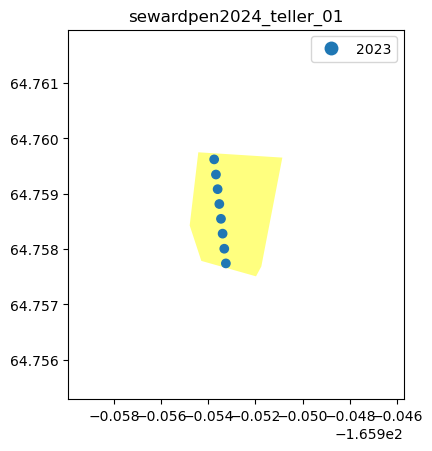

In [19]:
ax = footprint_uav_gdf.iloc[[SITE_IDX]].plot(color='yellow', alpha=0.5)
ax = footprint_uav_gdf.iloc[[SITE_IDX]].to_crs(3857).buffer(500).to_crs(4326).plot(ax=ax, color='k', alpha=0)
ax = atl08_30m_site.plot(ax=ax, column='year', categorical=True, legend=True)
#ax = ctx.add_basemap(ax=ax, source='https://titiler.maap-project.org/mosaics/7c763108-e047-4e3a-84ca-4c1364e21eae/tiles/{z}/{x}/{y}@1x?rescale=0%2C15&bidx=1&colormap_name=inferno', **ctx_kwargs)
ax.set_title(site)

### EarthData CMR search

In [20]:
# Find this at https://search.earthdata.nasa.gov/
COLLECTIONCONCEPTID_DICT = {
                        'ATL08.003': "C2003772626-NSIDC_ECS",
                        'ATL08.005': "C2144424132-NSIDC_ECS",
                        'ATL08.006': "C2565090645-NSIDC_ECS",
                        'GLIHT': "C2013348111-LPDAAC_ECS",
                        'ATL03.006': 'C2559919423-NSIDC_ECS'
}

In [21]:
# Page size: 150, number of results returned by page.
PAGESIZE = 150 
# Max page, number of pages to return before ending query.
MAXPAGE = 60
# Total max results will be PAGESIZE * MAXPAG

cmrP_list = []
for YEAR in search_dict['years_list']:
    
    cmrP = CmrProcess(mission = COLLECTIONCONCEPTID_DICT[search_dict['dataset']], 
                      dateTime=f"{YEAR}-{search_dict['minmonth']}-01T00:00:00Z,{YEAR}-{search_dict['maxmonth']}-30T23:59:59Z", 
                      lonLat = ','.join(str(e) for e in search_dict['bbox']),
                      pageSize=PAGESIZE,
                      maxPages=MAXPAGE)
    cmrP_list.append(cmrP)

In [22]:
resultList_year = [cmrP.run() for cmrP in cmrP_list]

Starting query
Results found on page: 1
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.
Starting query
Results found on page: 1
No hits on page number: 2, ending search.
No hits on page number: 3, ending search.


In [23]:
dict_results = dict(zip(search_dict['years_list'], resultList_year))

In [24]:
[print(f'{YEAR}: {len(dict_results[YEAR])}') for YEAR in search_dict['years_list']]

# Get one large list with all years
atlas_granule_list = [item for sublist in resultList_year for item in sublist]
print(f"\n{len(atlas_granule_list)} total granules in search results list")

print('\nNote: After filtering, final # of ATL08 granules will be a subset of this total.')

2019: 3
2020: 2
2021: 1
2022: 3
2023: 2
2024: 1

12 total granules in search results list

Note: After filtering, final # of ATL08 granules will be a subset of this total.


In [25]:
atlas_granule_list

['https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2019.06.17/ATL08_20190617143416_12270303_006_02.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2019.07.30/ATL08_20190730010431_04880405_006_02.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2019.09.16/ATL08_20190916101407_12270403_006_02.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2020.06.14/ATL08_20200614211328_12270703_006_01.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2020.07.27/ATL08_20200727074347_04880805_006_01.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2021.06.13/ATL08_20210613035251_12271103_006_01.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2022.06.11/ATL08_20220611103226_12271503_006_01.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2022.07.23/ATL08_20220723210252_04881605_006_02.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL08.006/2022.09.10/ATL08_20220910061223_12271603_006_01.h5',
 'https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL

## Get an ATL03 and ATL08 (100m; from NSIDC) orbit pair
Note - we're only able to get ATL03 photons classified according to the NSIDC ATL08 100m segment data

### Select specific granule from CMR search results list

In [26]:
dataset_list_for_export = ['land_segments/latitude','land_segments/longitude',
                           'land_segments/solar_elevation','land_segments/h_dif_ref', 'land_segments/sigma_topo',
                           'land_segments/msw_flag','land_segments/segment_snowcover','land_segments/segment_watermask','land_segments/night_flag','land_segments/segment_landcover',
                          'land_segments/canopy/h_canopy','land_segments/canopy/n_toc_photons','land_segments/canopy/n_ca_photons'
                          ]

dataset_terrain_list_for_export = ['land_segments/terrain/h_te_best_fit','land_segments/terrain/h_te_interp','land_segments/terrain/h_te_max','land_segments/terrain/h_te_mean','land_segments/terrain/h_te_median',
                                   'land_segments/terrain/h_te_min','land_segments/terrain/h_te_mode','land_segments/terrain/h_te_rh25','land_segments/terrain/h_te_skew','land_segments/terrain/h_te_std',
                                   'land_segments/terrain/h_te_uncertainty', 'land_segments/terrain/terrain_slope']

#dataset_list_for_export = dataset_list_for_export.append(dataset_terrain_list_for_export)

In [27]:
%%time
DEBUG = False

# def get_gdf_xy_4326_to_6933(atl08_gdf):
    
#     ### Define in (WGS84) and out (NSIDC EASE-Grid 2.0 Global) projections in order to plot
#     inproj = pyproj.Proj(init='epsg:4326')
#     outproj = pyproj.Proj(init='epsg:6933')

#     ### ATL08: convert WGS84 coordinates to EPSG grid
#     # Get x,y of valid ATL08
#     atl08_gdf['x'] , atl08_gdf['y'] = pyproj.transform(inproj, outproj, atl08_gdf.lon[valid_atl08].to_numpy(), atl08_gdf.lat[valid_atl08].to_numpy())
    
#     return atl08_gdf

class_name_list = ['Noise','Ground','Canopy','Top of canopy']
class_color_list = ['lightgrey','brown','lightgreen','darkgreen']

def classname_atl03(atl03_gdf, class_color_list, class_name_list):
    '''Function to assign name to ATL03 photon class'''
    # Add class names and colors
    class_list = [-1, 0, 1, 2, 3]

    atl03_gdf['class_name']  = pd.cut(atl03_gdf['class'], class_list , labels = class_name_list)
    atl03_gdf['color']  = pd.cut(atl03_gdf['class'], class_list , labels = class_color_list)
    
    return atl03_gdf

def get_atlas_atl03_atl08(g, bbox=search_dict['bbox'], BUF_ATL08 = 100):
    '''Using an ATLAS granule name, return quality filtered ATL08 and corresponding ATL03 classified photons
    '''
    ### Determine extent for clip
    minlon, minlat, maxlon, maxlat = bbox
    bbox_gdf = gpd.GeoDataFrame(index=[0], crs=4326,  geometry= [shapely.geometry.box(*search_dict['bbox'])])

    g1, g2, g3, g4, g5 = g.split('_')
    atl03_filename = g.replace('https://n5eil01u.ecs.nsidc.org/DP5','/css/icesat-2').replace('ATL08','ATL03')
    atl08_filename = g.replace('https://n5eil01u.ecs.nsidc.org/DP5','/css/icesat-2')
    print(atl03_filename)
    print(atl08_filename)
    
    #if True:
    try:
        atl08_file = h5py.File(atl08_filename, 'r')
        if DEBUG: print(list(atl08_file))

        # Get beamlist from ATL08
        beamlist = [group for i, group in enumerate(list(atl08_file)) if 'gt' in group]
        if DEBUG: print(beamlist)

        atl03_file = h5py.File(atl03_filename, 'r')
        if DEBUG: print(list(atl03_file))

        ### Open the input h5 files
        # Open the ATL03 file
        atl03_fid = h5io.ATL03H5File(atl03_filename)
        atl03_fid.open_h5()

        # Open the ATL08 file
        atl08_fid = h5io.ATL08H5File(atl08_filename)
        atl08_fid.open_h5()

        beamlist = [ beam for beam in atl08_fid.beams ]
        print(f'All beams: {beamlist}')

        ### Select a power beam
        # Which beams are power/weak depends on the orientation of the satellite
        atlas_orientation = atl03_fid.get_atlas_orientation()
        if atlas_orientation == 'backward':
            power_beams = [beam for beam in atl03_fid.beams if beam.endswith('l')]
        elif atlas_orientation == 'forward':
            power_beams = [beam for beam in atl03_fid.beams if beam.endswith('r')]
        else:
            print('ATLAS orientation in transition, do not use')

        print(f'Power beams: {power_beams}')

        for beam in power_beams:
            # Is it night or day?
            night_flag = atl08_fid.get_dataset(beam, 'land_segments/night_flag')
            print(f'{sum(night_flag)/night_flag.size:.4f}% of the land segments are night time in power beam {beam}')
        ###
        ### Export ATL08 data to dataframe
        ###
        atl08_df_list = []
        for beam in power_beams:
            df = atl08_fid.export_shots(beam, subset=False, dataset_list=dataset_list_for_export + dataset_terrain_list_for_export)
            df['beam'] = beam
            df['spot'] = 1 # TODO get this directly since its needed for FilterUtils
            atl08_df_list.append(df)    
        #atl08_df = pd.concat([ atl08_fid.export_shots(beam, subset=False, dataset_list=dataset_list_for_export + dataset_terrain_list_for_export) for beam in power_beams]) 
        atl08_df = pd.concat(atl08_df_list)
        
        #atl08_df = FilterUtils.prep_filter_atl08_qual(atl08_df)
        # Rename some cols for FilterUtils
        atl08_df['h_can'] = atl08_df['h_canopy']
        atl08_df.rename(columns={'segment_snowcover': 'snowcover'}, inplace=True)
        atl08_df['atl08_granule'] = os.path.basename(atl08_filename)
        atl08_df['datetime'] = pd.to_datetime(atl08_df.atl08_granule.str.split('_', expand=True)[1])
        atl08_df['y'] = atl08_df.datetime.dt.year
        atl08_df['m'] = atl08_df.datetime.dt.month
        atl08_df['d'] = atl08_df.datetime.dt.day
        atl08_df['doy'] = atl08_df.datetime.dt.dayofyear
        
        # Clip to bbox
        atl08_df.rename(columns={'longitude': 'lon', 'latitude': 'lat', 'night_flag':'night_flg'}, inplace=True)
        atl08_gdf = gpd.clip(GeoDataFrame(atl08_df, geometry=gpd.points_from_xy(atl08_df.lon, atl08_df.lat), crs='epsg:4326'), bbox_gdf)
        print(f'ATL08 dataframe: {atl08_gdf.shape}')
    
        ###
        ### Filter
        ###
        if atl08_gdf.shape[0] > 0:
            atl08_gdf = FilterUtils.filter_atl08_qual_v5(atl08_gdf, 
                                                         list_lc_h_can_thresh = None, thresh_h_can = None, thresh_h_can_unc = None
                                                        )
            atl08_gdf.rename(columns={'y':'year'}, inplace=True)

        ### Get x,y for ATL08 lon,lat
        valid_atl08 = ~numpy.isnan(atl08_gdf.lon.to_numpy())
        valid_atl08 &= ~numpy.isnan(atl08_gdf.lat.to_numpy())

        print(f'ATL08 dataframe (filtered): {atl08_gdf.shape}')
        
        ### Define in (WGS84) and out (NSIDC EASE-Grid 2.0 Global) projections in order to plot
        inproj = pyproj.Proj(init='epsg:4326')
        outproj = pyproj.Proj(init='epsg:6933')
        
        ### ATL08: convert WGS84 coordinates to EPSG grid
        # Get x,y of valid ATL08
        atl08_gdf['x'] , atl08_gdf['y'] = pyproj.transform(inproj, outproj, atl08_gdf.lon[valid_atl08].to_numpy(), atl08_gdf.lat[valid_atl08].to_numpy())

        if atl08_gdf.shape[0] > 0:
            
            ### Export ATL03 to dataframe - this is an example of an export without the use of ATL08 to tell us which are valid and not valid
            if False:
                atl03_df = pd.concat([ atl03_fid.export_shots(beam, subset=False, dataset_list=['heights/h_ph','heights/lat_ph','heights/lon_ph']) for beam in beamlist]) 
                print(f'ATL03 dataframe: {atl03_df.shape}')

            ###
            ### Extract ATL03 photon x,y,z and link with photon classification from ATL08
            ###
            longitude, latitude, elevation  = [numpy.concatenate([atl03_fid.get_coordinates(beam, ht=True)[i] for beam in power_beams]) for i in range(0,3)]
            ph_class =  numpy.concatenate([atl03_fid.get_photon_labels(beam, atl08_fid) for beam in power_beams], axis=None)
            ph_height = numpy.concatenate([atl03_fid.get_photon_height(beam, atl08_fid) for beam in power_beams], axis=None)
            ph_qual =   numpy.concatenate([atl03_fid.get_quality_flag(beam) for beam in power_beams], axis=None)

            # Filter by latitude from BBOX
            longitude, latitude, elevation, ph_class, ph_height, ph_qual = [v[(latitude < maxlat) & (latitude > minlat)] for v in [longitude, latitude, elevation, ph_class, ph_height, ph_qual]]

            ### ATL03: convert WGS84 coordinates to EPSG grid 
            valid = ~numpy.isnan(longitude)
            valid &= ~numpy.isnan(latitude)
            x,y = pyproj.transform(inproj, outproj, longitude[valid], latitude[valid])

            ### Build the ATL03 geodataframe you want (with classnames)
            atl03_df = pd.DataFrame({'lon':longitude[valid], 'lat':latitude[valid], 'elev':elevation[valid], 'class':ph_class[valid], 'height':ph_height[valid], 'quality':ph_qual[valid]})
            atl03_gdf = GeoDataFrame(atl03_df, geometry=gpd.points_from_xy(atl03_df.lon, atl03_df.lat), crs='epsg:4326')

            # Get class names
            atl03_gdf = classname_atl03(atl03_gdf, class_color_list, class_name_list)
            
            ### ATL08: convert WGS84 coordinates to EPSG grid
            # Get x,y of valid ATL08
            atl03_gdf['x'], atl03_gdf['y'] = pyproj.transform(inproj, outproj, atl03_gdf.lon, atl03_gdf.lat)

            print(f'ATL03 dataframe: {atl03_gdf.shape}')

            # Buffer ATL08 and use to clip ATL03
            #
            # TODO: make a copy of ATL08 that gets buffered, used for clip, then removed
            atl08_gdf_TMP = atl08_gdf.copy()
            geom_buf = atl08_gdf['geometry'].to_crs(3857).buffer(BUF_ATL08).to_crs(4326)
            atl08_gdf_TMP['geometry'] = geom_buf

            # Easy way of getting beam field for atl03
            atl03_gdf_list = []
            for beam in power_beams: 
                tmp = gpd.clip(atl03_gdf.drop_duplicates(), atl08_gdf_TMP[atl08_gdf_TMP.beam == beam])
                tmp['beam'] = beam
                atl03_gdf_list.append(tmp)
            atl03_gdf = pd.concat(atl03_gdf_list)
            print(f'ATL03 dataframe filtered (clipped with {BUF_ATL08} m buffered ATL08): {atl03_gdf.shape}\n')

            # atl08_gdf['atl08_granule'] = os.path.basename(atl08_filename)
            atl03_gdf['atl03_granule'] = os.path.basename(atl03_filename)
            
            # atl08_gdf['datetime'] = pd.to_datetime(atl08_gdf.atl08_granule.str.split('_', expand=True)[1])
            # atl08_gdf['year'] = atl08_gdf.datetime.dt.year
            # atl08_gdf['doy'] = atl08_gdf.datetime.dt.dayofyear
            
            atl03_gdf['datetime'] = pd.to_datetime(atl03_gdf.atl03_granule.str.split('_', expand=True)[1])
            atl03_gdf['year'] = atl03_gdf.datetime.dt.year
            atl03_gdf['doy'] = atl03_gdf.datetime.dt.dayofyear

        else:
            atl08_gdf = None
            atl03_gdf = None
            print(f'ATL03 dataframe is NA\n')

        ### Close the H5 files for ATL03 and ATL08
        atl03_fid.close_h5()
        atl08_fid.close_h5()
        return atl08_gdf, atl03_gdf
    except:
        print('Failed to open one of the granules.\n')

        return None, None
        #return atl08_df

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 12.9 µs


## Get ATL03 and ATL08 for bbox
 - Note: filtering by h_canopy if turned OFF - some tundra ATL08 100m obs dont have valid h_canopy and thus will get filtered out unless  

In [28]:
import importlib
importlib.reload(FilterUtils)

<module 'FilterUtils' from '/home/pmontesa/code/icesat2/FilterUtils.py'>

In [29]:
%%time
results_list = [get_atlas_atl03_atl08(g, bbox=search_dict['bbox'], BUF_ATL08 = 125) for g in atlas_granule_list]

/css/icesat-2/ATLAS/ATL03.006/2019.06.17/ATL03_20190617143416_12270303_006_02.h5
/css/icesat-2/ATLAS/ATL08.006/2019.06.17/ATL08_20190617143416_12270303_006_02.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
0.0000% of the land segments are night time in power beam gt1l
0.0000% of the land segments are night time in power beam gt2l
0.0000% of the land segments are night time in power beam gt3l
ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2019.07.30/ATL03_20190730010431_04880405_006_02.h5
/css/icesat-2/ATLAS/ATL08.006/2019.07.30/ATL08_20190730010431_04880405_006_02.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
0.0000% of the land segments are night time in power beam gt1l
0.0000% of the land segments are night time in power beam gt2l
0.0000% of the land segments are night time in power beam gt3l


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2019.09.16/ATL03_20190916101407_12270403_006_02.h5
/css/icesat-2/ATLAS/ATL08.006/2019.09.16/ATL08_20190916101407_12270403_006_02.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1r', 'gt2r', 'gt3r']
1.0000% of the land segments are night time in power beam gt1r


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


1.0000% of the land segments are night time in power beam gt2r
1.0000% of the land segments are night time in power beam gt3r
ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2020.06.14/ATL03_20200614211328_12270703_006_01.h5
/css/icesat-2/ATLAS/ATL08.006/2020.06.14/ATL08_20200614211328_12270703_006_01.h5


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
0.0000% of the land segments are night time in power beam gt1l
0.0000% of the land segments are night time in power beam gt2l
0.0000% of the land segments are night time in power beam gt3l
ATL08 dataframe: (2, 35)
	After sliderule:                                                                          2 observations in the dataframe.
	After msw_flag=0:                                                                          2 observations in the dataframe.
	After beam_type=strong:                                                                          2 observations in the dataframe.
	After snowcover=1:                                                                          2 observations in the dataframe.
	After h_can threshold OFF - no h_can filtering:                                                                2 observations in the dataframe.
	After NO misc thresholds (h_can_unc 

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
<timed exec>:153: DeprecationWarning: This function is deprecated. See: https://pyproj4.githu

ATL03 dataframe: (12058, 11)
ATL03 dataframe filtered (clipped with 125 m buffered ATL08): (3754, 12)

/css/icesat-2/ATLAS/ATL03.006/2020.07.27/ATL03_20200727074347_04880805_006_01.h5
/css/icesat-2/ATLAS/ATL08.006/2020.07.27/ATL08_20200727074347_04880805_006_01.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
0.0997% of the land segments are night time in power beam gt1l
0.0191% of the land segments are night time in power beam gt2l
0.0443% of the land segments are night time in power beam gt3l
ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2021.06.13/ATL03_20210613035251_12271103_006_01.h5
/css/icesat-2/ATLAS/ATL08.006/2021.06.13/ATL08_20210613035251_12271103_006_01.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1r', 'gt2r', 'gt3r']
0.0000% of the land segments are night time in power beam gt1r
0.0000% of the land segments are night ti

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2022.06.11/ATL03_20220611103226_12271503_006_01.h5
/css/icesat-2/ATLAS/ATL08.006/2022.06.11/ATL08_20220611103226_12271503_006_01.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1r', 'gt2r', 'gt3r']
0.9112% of the land segments are night time in power beam gt1r
0.8899% of the land segments are night time in power beam gt2r
0.8566% of the land segments are night time in power beam gt3r


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (2, 35)
	After sliderule:                                                                          2 observations in the dataframe.
	After msw_flag=0:                                                                          0 observations in the dataframe.
	After beam_type=strong:                                                                          0 observations in the dataframe.
	After snowcover=1:                                                                          0 observations in the dataframe.
	After h_can threshold OFF - no h_can filtering:                                                                0 observations in the dataframe.
	After NO misc thresholds (h_can_unc , seg_cover, sol_el, sig_topo, h_dif_ref): 		              0 observations in the dataframe.
	After month filters: 6-9
	After all quality filtering: 		                                       0 observations in the output dataframe.
ATL08 dataframe (filtered): (0, 36)
ATL03 dataframe is NA


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2022.09.10/ATL03_20220910061223_12271603_006_01.h5
/css/icesat-2/ATLAS/ATL08.006/2022.09.10/ATL08_20220910061223_12271603_006_01.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1r', 'gt2r', 'gt3r']
1.0000% of the land segments are night time in power beam gt1r
1.0000% of the land segments are night time in power beam gt2r
1.0000% of the land segments are night time in power beam gt3r


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2023.06.09/ATL03_20230609171117_12271903_006_02.h5
/css/icesat-2/ATLAS/ATL08.006/2023.06.09/ATL08_20230609171117_12271903_006_02.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
0.0000% of the land segments are night time in power beam gt1l
0.0000% of the land segments are night time in power beam gt2l
0.0000% of the land segments are night time in power beam gt3l


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

/css/icesat-2/ATLAS/ATL03.006/2023.09.08/ATL03_20230908125040_12272003_006_02.h5
/css/icesat-2/ATLAS/ATL08.006/2023.09.08/ATL08_20230908125040_12272003_006_02.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
1.0000% of the land segments are night time in power beam gt1l
1.0000% of the land segments are night time in power beam gt2l
1.0000% of the land segments are night time in power beam gt3l


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ATL08 dataframe: (3, 35)
	After sliderule:                                                                          3 observations in the dataframe.
	After msw_flag=0:                                                                          3 observations in the dataframe.
	After beam_type=strong:                                                                          3 observations in the dataframe.
	After snowcover=1:                                                                          3 observations in the dataframe.
	After h_can threshold OFF - no h_can filtering:                                                                3 observations in the dataframe.
	After NO misc thresholds (h_can_unc , seg_cover, sol_el, sig_topo, h_dif_ref): 		              3 observations in the dataframe.
	After month filters: 6-9
	After all quality filtering: 		                                       3 observations in the output dataframe.
ATL08 dataframe (filtered): (3, 36)


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
<timed exec>:153: DeprecationWarning: This function is deprecated. See: https://pyproj4.githu

ATL03 dataframe: (1346, 11)
ATL03 dataframe filtered (clipped with 125 m buffered ATL08): (429, 12)

/css/icesat-2/ATLAS/ATL03.006/2024.07.19/ATL03_20240719101936_04882405_006_01.h5
/css/icesat-2/ATLAS/ATL08.006/2024.07.19/ATL08_20240719101936_04882405_006_01.h5
All beams: ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
Power beams: ['gt1l', 'gt2l', 'gt3l']
0.7133% of the land segments are night time in power beam gt1l
0.7030% of the land segments are night time in power beam gt2l
0.6928% of the land segments are night time in power beam gt3l
ATL08 dataframe: (0, 35)
ATL08 dataframe (filtered): (0, 35)
ATL03 dataframe is NA

CPU times: user 49.8 s, sys: 9.11 s, total: 58.9 s
Wall time: 1min 33s


/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
<timed exec>:130: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


### Build the final ICESat-2 dataframes

In [30]:
len(results_list )

12

In [31]:
atl08_gdf = pd.concat([results_list[idx][0] for idx in list(range(0, len(results_list)))])
atl03_gdf = pd.concat([results_list[idx][1] for idx in list(range(0, len(results_list)))])

In [32]:
atl08_gdf.shape

(5, 38)

In [33]:
atl03_gdf.shape

(4183, 16)

### Extract other rasters to ATL03

In [34]:
DSM_DIR = f'{OUTDIR}/DSM_COG'
DTM_DIR = f'{OUTDIR}/DTM_COG'

fn_uavdsm_list = sorted(glob.glob(f'{DSM_DIR}/*.tif'))
fn_uavdtm_list = sorted(glob.glob(f'{DTM_DIR}/*.tif'))
fn_uavdsm_list

['/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/council_01_20240812_100m_dsm.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/council_02_20240812_100m_dsm.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/kougarok_01_20240811_100m_dsm.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/kougarok_02_20240811_100m_dsm.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/kougarok_03_20240811_100m_dsm.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/kougarok_04_20240813_100m_dsm.tif',
 '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/DSM_COG/kougarok_05_20240814_100m_agl_dsm.tif',
 '/explore/

## Extract the ATL03 photon x,y,z coordinates and classification (using ATL08)

## Plot the classified photons

In [35]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

transect_length_num_photons = int(1e4)

In [36]:
ctx_kwargs

{'crs': 4326, 'attribution_size': 0}

## Select a transect, Generate a transect plot

In [58]:
start_photon_num, transect_length_num_photons = 0, 100000

In [59]:
atl08_30m_site.doy.unique()
atl08_gdf.doy.unique()

array([166, 251])

In [60]:
import sys
sys.path.append('/home/pmontesa/code/above-shrubs/notebooks')
import plotlib

In [61]:
importlib.reload(plotlib)

<module 'plotlib' from '/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py'>

In [62]:
atl03_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4183 entries, 666 to 428
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   lon            4183 non-null   float64       
 1   lat            4183 non-null   float64       
 2   elev           4183 non-null   float32       
 3   class          4183 non-null   int8          
 4   height         4183 non-null   float64       
 5   quality        4183 non-null   int8          
 6   geometry       4183 non-null   geometry      
 7   class_name     4183 non-null   category      
 8   color          4183 non-null   category      
 9   x              4183 non-null   float64       
 10  y              4183 non-null   float64       
 11  beam           4183 non-null   object        
 12  atl03_granule  4183 non-null   object        
 13  datetime       4183 non-null   datetime64[ns]
 14  year           4183 non-null   int64         
 15  doy         

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:238: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



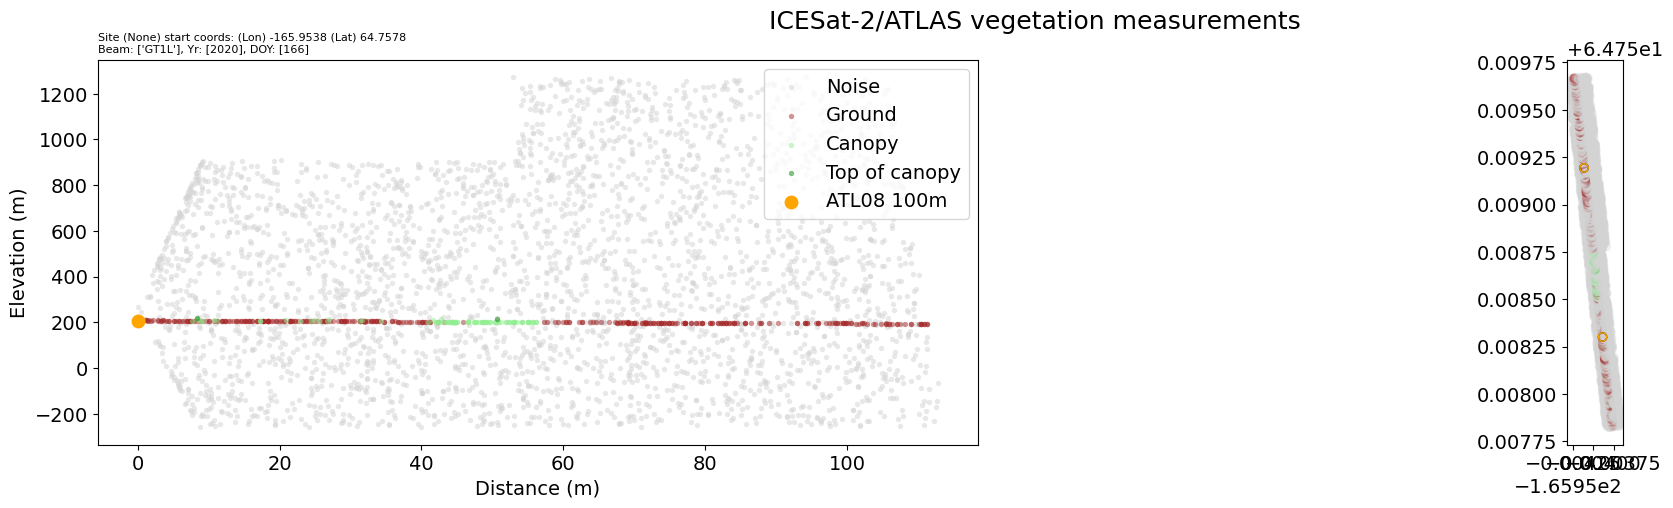

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:238: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:242: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



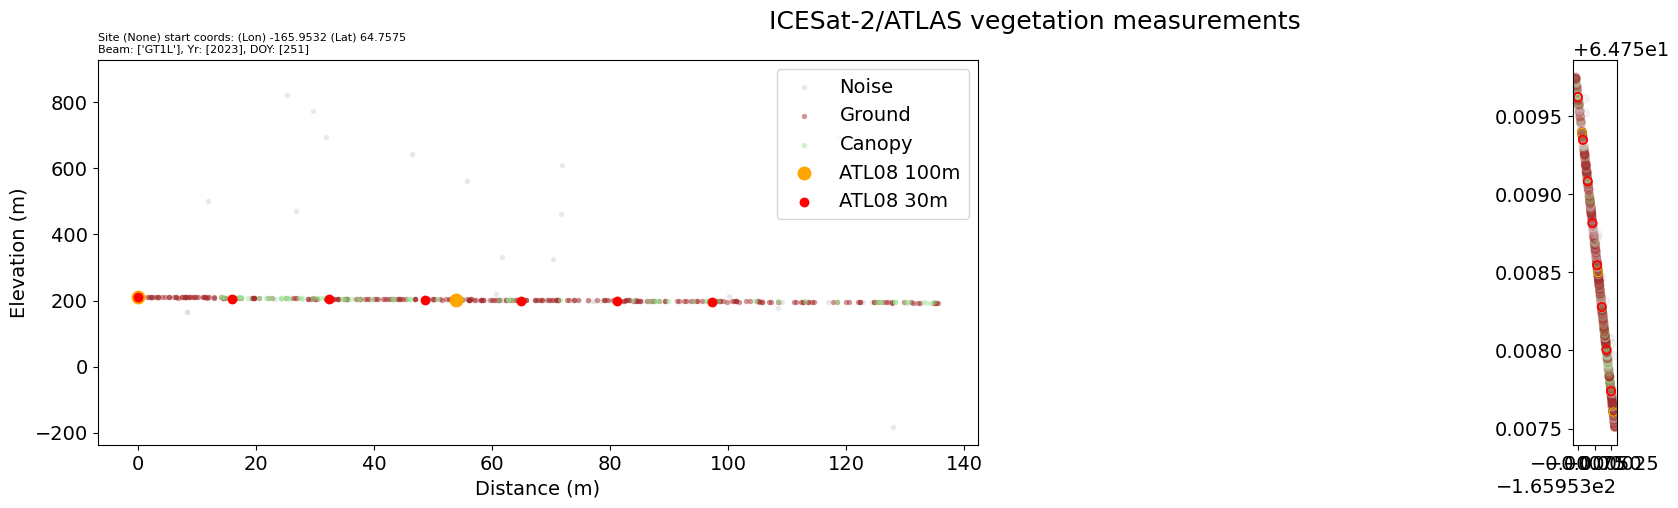

In [63]:
plotlib.plot_atl03_transect(start=start_photon_num, transect_length=transect_length_num_photons, DO_HEIGHT=False, atl03_gdf=atl03_gdf, atl08_100m_gdf=atl08_gdf, atl08_30m_gdf=atl08_30m_site)

/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



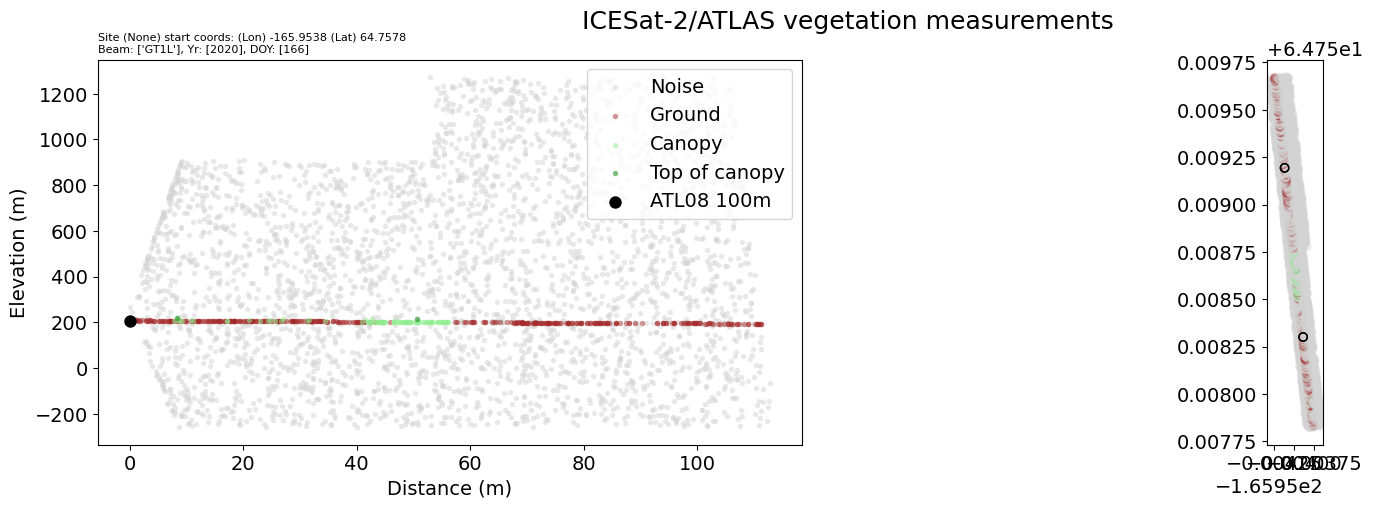

/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



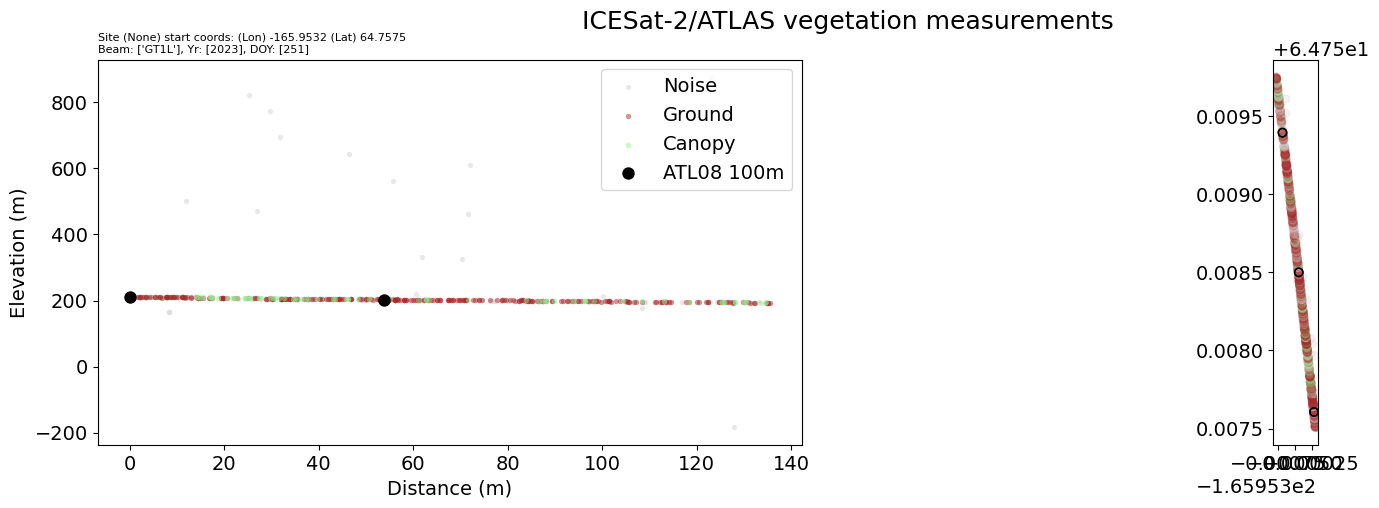

In [44]:
plotlib.plot_atl03_transect(start=start_photon_num, transect_length=transect_length_num_photons, DO_HEIGHT=False, atl03_gdf=atl03_gdf, atl08_100m_gdf=atl08_gdf, atl08_30m_gdf=atl08_30m_site)

/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



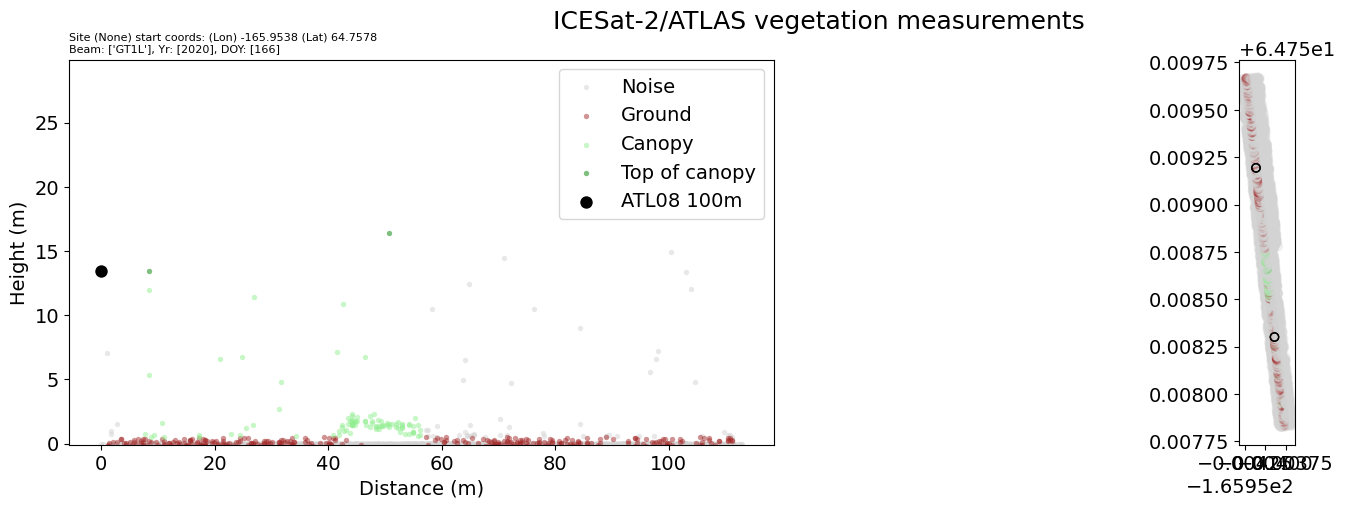

/home/pmontesa/code/above-shrubs/notebooks/plotlib.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



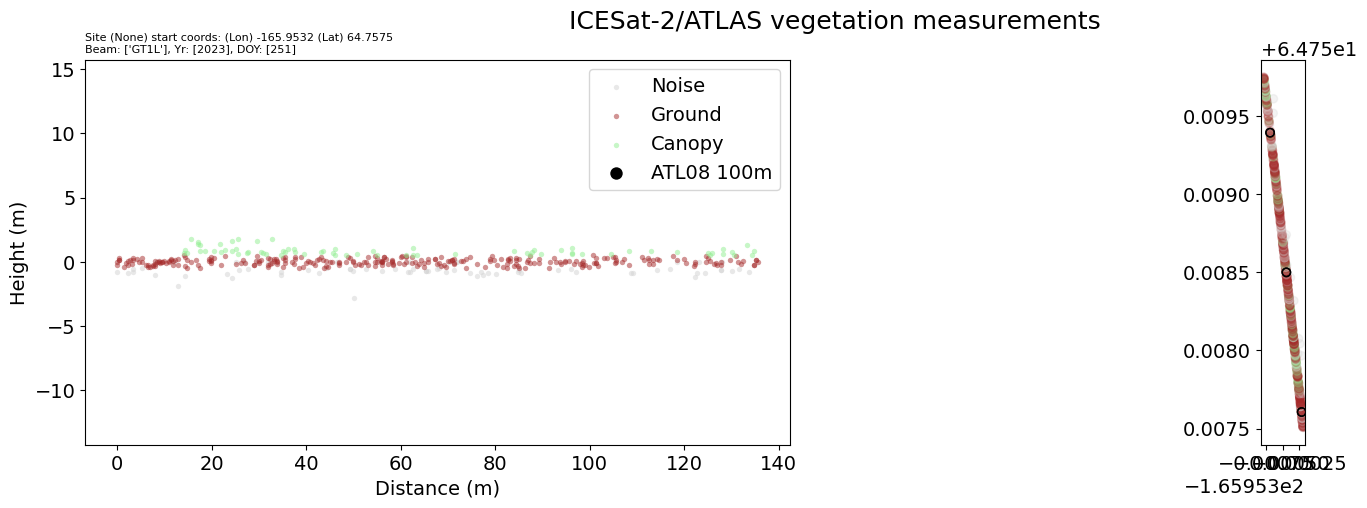

In [45]:
plotlib.plot_atl03_transect(start=start_photon_num, transect_length=transect_length_num_photons, DO_HEIGHT=True, atl03_gdf=atl03_gdf, atl08_100m_gdf=atl08_gdf, atl08_30m_gdf=atl08_30m_site)

## Generate an interactive ATL03 transect plot showing classified photons

In [566]:
# #nrecords = x.shape[0]
# ipywidgets.interact(update, 
#                     start=ipywidgets.IntSlider(min=int(1e3), max=int(2e6), 
#                                                        step=int(1e2), value=start_photon_num, 
#                                                        continuous_update=False))

## Histogram of classified photon heights

In [47]:
# Subset the transect to a certain section
atl03_gdf_transect = plotlib.subset_atl03(atl03_gdf, start=start_photon_num, transect_length=transect_length_num_photons)

if atl03_gdf_transect.shape[0] == 0:
    print('Find another transect - this has 0 photons')

NameError: name 'classname_atl03' is not defined

In [ ]:
plotnine.options.figure_size = (6, 4)

#atl03_gdf_all['class'] = atl03_gdf_all['class'].apply(str)
#atl03_gdf_transect['class_str'] = atl03_gdf_transect['class'].apply(str)
class_name_list = ['Noise','Ground','Canopy','Top of canopy']
class_color_list = ['lightgrey','brown','lightgreen','darkgreen']

(
      ggplot(atl03_gdf_transect[atl03_gdf_transect['class'] > 0], aes('height', fill='class_name'))
        + labs(x = 'Photon height (m)')
        + scale_fill_manual(values = class_color_list, name='Photon class')
        + geom_histogram(binwidth=0.1)
        + geom_vline(xintercept=0, linetype='dashed', size=0.5, color='white')
        + facet_wrap(' ~ beam + year + doy', ncol=4)#, scales = 'free_x')
    + coord_flip()
    #+ coord_cartesian(xlim = (-2,10))
    + theme_bw() 
)

### Export ATL03 and ATL08 gdfs
remove Noise and save to a GPKG of classified ATL03

In [48]:
SUBSET_TRANSECT = False

In [49]:
if SUBSET_TRANSECT:
    atl03_gdf_export = subset_atl03(atl03_gdf, start=start_photon_num, transect_length=atl03_gdf.shape[0])
    out_atl03_fn = os.path.join(OUTDIR, f'{site}_classified_photons_ATL03_subset_start{start_photon_num}_len{transect_length}' + '.gpkg')
else:
    atl03_gdf_export = atl03_gdf
    out_atl03_fn = os.path.join(OUTDIR, f'{site}_classified_photons_ATL03' + '.gpkg')
    
atl03_gdf_export = atl03_gdf_export[~atl03_gdf_export['class_name'].isin(['Noise'])]#.cx[minlon:maxlon, minlat:maxlat]
atl03_gdf_export['class_name'] = atl03_gdf_export['class_name'].astype(str)
atl03_gdf_export['color'] = atl03_gdf_export['color'].astype(str)

out_atl08_fn = os.path.join(OUTDIR, f'{site}_ATL08' + '.gpkg')

atl03_gdf_export.to_file(out_atl03_fn, driver='GPKG')
atl08_gdf.to_file(out_atl08_fn, driver='GPKG')

print(out_atl03_fn)
print(out_atl08_fn)

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/sewardpen2024_teller_01_classified_photons_ATL03.gpkg
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/sewardpen2024_teller_01_ATL08.gpkg


## Generate an interactive map of ATL03 photons with ATL08 obs
- Reminder - these are quality filtered using ATL08 100m from NSIDC using our FilterUtils modified with height filter OFF

### Map ATL03 photon classes

In [571]:
import importlib
importlib.reload(maplib)
from folium import plugins

In [572]:
%%time

if False:
    m_atl03 = maplib.ADD_ATL03_OBS_TO_MAP(atl03_gdf_export[atl03_gdf_export['class'] > 0].sample(frac=1), maplib.MAP_FOLIUM(lat_start =numpy.mean(atl03_gdf_transect.lat), lon_start = numpy.mean(atl03_gdf_transect.lon) ) )

    #plugins.MousePosition().add_to(m_atl03)
    m_atl03

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


### Map ATL03 photon heights

In [573]:
if False:
    maplib.ADD_OBS_TO_MAP(atl03_gdf_export, 'height', 
                          maplib.MAP_FOLIUM(zoom_start = 12, lat_start =numpy.mean(atl03_gdf_export.lat), lon_start = numpy.mean(atl03_gdf_export.lon) ),
                          RADIUS=5.5, MAP_TITLE='Vegetation height from  ATL03 Top of Canopy', VMAX = 4)

### Map ATL08 heights

In [574]:
if False:
    maplib.ADD_OBS_TO_MAP(atl08_gdf, 'h_can', 
                          m_atl03,
                          RADIUS=50, MAP_TITLE='Vegetation height from  ATL03 Top of Canopy & ATL08', VMAX = 4)